Read in the necessary libraries

In [562]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

Read in the necessary data

In [563]:
df_detailed_listings = pd.read_csv('./resource/detailed_listings.csv')


In [564]:
# df_detailed_reviews = pd.read_csv('./resource/raw_data/detailed_reviews.csv')
# df_listings = pd.read_csv('./resource/raw_data/listings.csv')
# df_reviews = pd.read_csv('./resource/raw_data/reviews.csv')

Overview of the data - comparing detailed listings df to reduced listings df

In [565]:
# columns_detailed_listings = df_detailed_listings.columns
# columns_listings = df_listings.columns

# detailed_listings_exclusive_features = [x for x in columns_detailed_listings if x not in columns_listings]
# listings_exclusive_features = [x for x in columns_listings if x not in columns_detailed_listings]

# print(f'Features which are only in the detailed listings csv: \n{detailed_listings_exclusive_features}\n')
# print(f'Features which are only in the reduces listings csv: \n{listings_exclusive_features}')

Apparently all columns from the reduced listings csv are included in the detailed listings csv, except for the column 'neighbourhood_group'. After looking through all column labels it is likely the information out of the 'neighbourhood_group' is also inlcuded in the detailed listings csv, but with a diffrent columnname.

In [566]:
# df_listings.neighbourhood_group.value_counts()

In [567]:
# df_detailed_listings.neighbourhood_group_cleansed.value_counts()

The data regarding the 'neighbourhood_group' is also included in the detailed listings csv in the 'neighbourhood_group_cleansed' column. We therefore only need the detailed listings csv, without missing out on features regarding the listings.

In [568]:
# print(df_detailed_reviews.info())
# print(df_reviews.info())

Comparing the reviews and detailed reviews csv it becomes clear that the detailed reviews includes all informations necessary. For further analysis we focus on the detailed listings and detailed reviews csv.

In [569]:
# print(df_detailed_reviews.info())

In [570]:
# print(df_detailed_listings.info())

Taking a look at the shape and dimensions of the two dataframes shows that there are way more reviews than listings, propably because there are multiple reviews for the same listings included in the review dataframe.

In [571]:
# # comparing the entries of both lists and store the ones which aren't present in both to a new list via list comprehension:
# # listings_without_reviews = [x for x in df_detailed_listings.id.unique() if x not in df_detailed_reviews.listing_id.unique()]
# # print(f'listings without a review: {len(listings_without_reviews)}')

# print(f'Unique IDs in the review df: {df_detailed_reviews.listing_id.nunique()}')
# print(f'Unique IDs in the listings df: {df_detailed_listings.id.nunique()}')

# # to save time computing this method of simply substracting the lists from each other is used. Both methods produce the same output.
# print(f'Listings without a review: {df_detailed_listings.id.nunique() - df_detailed_reviews.listing_id.nunique()}')

For further investigation of the data we merge the two dataframes on the respective ID columns.

In [572]:
# # renaming the 'id' column into 'review_id':
# df_r = df_detailed_reviews.rename(columns={'id': 'review_id'}).copy()

# # renaming the 'id' column into 'listing_id':
# df_l = df_detailed_listings.rename(columns={'id': 'listing_id'}).copy()

In [573]:
# Doublecheck if everything went well
# df_r.review_id.nunique(), df_detailed_reviews.id.nunique(), df_l.listing_id.nunique(), df_detailed_listings.id.nunique()

In [574]:
# df = pd.merge(df_l, df_r, on='listing_id')

In [575]:
# print(f'Shape of df_detailed_reviews: {df_detailed_reviews.shape}')
# print(f'Shape of df_detailed_listings: {df_detailed_listings.shape}')
# print(f'Shape of the merged dataframe df: {df.shape}')

In [576]:
# doublecheck if the dataframes are merged correctly, using distinctive columns:
# df.groupby(['listing_id'])[['listing_id', 'first_review', 'comments']].head(20)

Save the raw, unplrocessed dataframe containing all data to analyze into a zipped csv file.

In [577]:
# df.to_csv('./resource/airbnb_berlin_data.csv.zip', index_label='listing_id', compression='zip')

In [578]:
df_detailed_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

The raw data containes a lot of information we do not want to process or use for predicting any features, so we drop them. For our purpose features which contain for example urls or similar should be droped befor starting to analyze the data.

In [579]:
df_listing_cleaned = df_detailed_listings.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', \
                                      'host_thumbnail_url', 'host_picture_url', 'latitude', 'longitude', 'calendar_updated', \
                                      'calendar_last_scraped', 'license'], axis=1).copy()

Furthermore there are also columns which contain no or way to few values to be valuable to our predictions and analysis. So they are droped as well.

In [580]:
# Searching for columns missing all data:
print(df_listing_cleaned.loc[:, df_listing_cleaned.isnull().all()].columns)

# drop columns which have no values
print(len(df_listing_cleaned.columns))
df_listing_cleaned = df_listing_cleaned.dropna(axis=1, how='all')
print(len(df_listing_cleaned.columns))

# df_listing_cleaned = df_listing_cleaned.drop(columns=['bathrooms'], axis=1).copy()

Index(['bathrooms'], dtype='object')
62
61


In [581]:
df_listing_cleaned.neighbourhood_group_cleansed.unique()

array(['Pankow', 'Friedrichshain-Kreuzberg', 'Mitte',
       'Treptow - Köpenick', 'Neukölln', 'Tempelhof - Schöneberg',
       'Charlottenburg-Wilm.', 'Marzahn - Hellersdorf',
       'Steglitz - Zehlendorf', 'Spandau', 'Reinickendorf', 'Lichtenberg'],
      dtype=object)

In [582]:
df_listing_cleaned.price.head()

0     $83.00
1    $180.00
2    $280.00
3     $70.00
4    $135.00
Name: price, dtype: object

In [583]:
df_listing_cleaned['price'] = df_listing_cleaned.price.str[1:].str.replace(',','').str.split('.').str[0].astype(int)

In [584]:
df_listing_cleaned.price.head()

0     83
1    180
2    280
3     70
4    135
Name: price, dtype: int64

In [585]:
df_analyze = df_listing_cleaned.groupby(['neighbourhood_group_cleansed']).aggregate(beds=('beds','mean'), price=('price','mean')).sort_values(by='price',ascending=False)

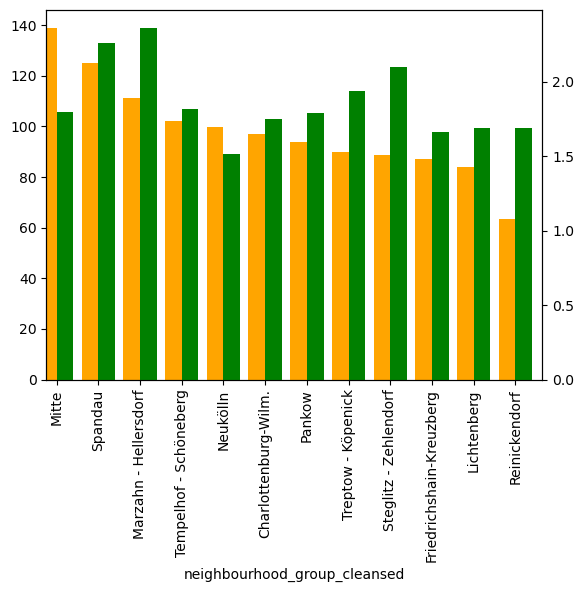

In [592]:
fig = plt.figure()

ax = fig.add_subplot()
ax2 = ax.twinx()

df_analyze.price.plot(kind='bar', ax=ax, width=0.4, position=1, color='orange')
df_analyze.beds.plot(kind='bar', ax=ax2, width=0.4, position=0, color='green')


plt.show()

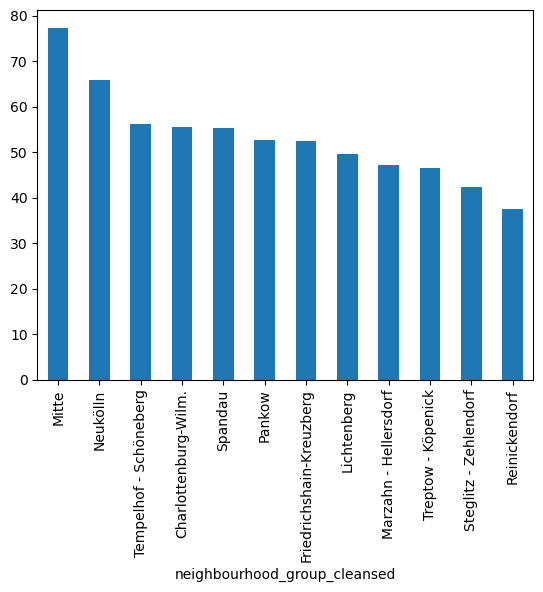

In [596]:
(df_analyze.price/df_analyze.beds).sort_values(ascending=False).plot(kind='bar');